## Pre Process


In [ ]:
! mkdir TRAIN
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/images.raw.gz
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/TRAIN/track_parms.csv
! mv images.raw.gz TRAIN
! mv track_parms.csv TRAIN
! mkdir VALIDATION
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/VALIDATION/images.raw.gz
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/VALIDATION/track_parms.csv
! mv images.raw.gz VALIDATION
! mv track_parms.csv VALIDATION

In [ ]:
import os
import sys
import gzip
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from tensorflow import keras

width  = 36
height = 100

# Open labels files so we can get number of samples and pass the
# data frames to the generators later
traindf = pd.read_csv('TRAIN/track_parms.csv')
valdf = pd.read_csv('VALIDATION/track_parms.csv')
STEP_SIZE_TRAIN = len(traindf)/32
STEP_SIZE_VAL = len(valdf)/32

#-----------------------------------------------------
# generate_arrays_from_file
#-----------------------------------------------------
# Create generator to read in images and labels
# (used for both training and validation samples)
def generate_arrays_from_file( labelsdf , dType):

	images_path = dType+'images.raw.gz'
	print( 'generator created for: ' + images_path)

	batch_input           = []
	batch_labels_phi      = []
	batch_labels_z        = []
	idx = 0
	ibatch = 0
	while True:  # loop forever, re-reading images from same file
		with gzip.open(images_path) as f:
			while True: # loop over images in file
			
				# Read in one image
				bytes = f.read(width*height)
				if len(bytes) != (width*height): break # break into outer loop so we can re-open file
				data = np.frombuffer(bytes, dtype='B', count=width*height)
				pixels = np.reshape(data, [width, height, 1], order='F')
				pixels_norm = np.transpose(pixels.astype(np.float) / 255., axes=(1, 0, 2) )
				
				# Labels
				phi = labelsdf.phi[idx]
				z   = labelsdf.z[idx]
				idx += 1

				# Add to batch and check if it is time to yield
				batch_input.append( pixels_norm )
				batch_labels_phi.append( phi )
				batch_labels_z.append( z )
				if len(batch_input) == 32 :
					ibatch += 1
					
					# Since we are training multiple loss functions we must
					# pass the labels back as a dictionary whose keys match
					# the layer their corresponding values are being applied to.
					labels_dict = {
						'phi_output' :  np.array(batch_labels_phi ),
						'z_output'   :  np.array(batch_labels_z   ),		
					}
					
					yield ( np.array(batch_input), labels_dict )
					batch_input      = []
					batch_labels_phi = []
					batch_labels_z   = []

			idx = 0
			f.close()


## Model

In [ ]:
# Model-2
def buildBranch(x):
  x = keras.layers.Conv2D(64,(3,6),strides=(1,6),activation="relu")(x)
  x = keras.layers.Conv2D(32,(3,6),strides=(1,6),activation="relu")(x)
  # x = keras.layers.Conv2D(64,(3,3),activation="relu")(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(16, activation="relu",name="common_out")(x)
  return x

def buildPhiBranch(x):
  x = keras.layers.Dense(1,activation="linear",name="phi_output")(x)
  return x

def buildZBranch(x, arg):
  x = keras.layers.concatenate([x,arg])
  x = keras.layers.Dense(32, activation="relu",name="z_dense1")(x)
  x = keras.layers.Dense(1,activation="linear",name="z_output")(x)
  return x

### model build

In [ ]:
inputs = keras.Input(shape=(100, 36, 1))
branch = buildBranch(inputs)
branch_phi = buildPhiBranch(branch)
branch_z = buildZBranch(branch,branch_phi)
model = keras.Model(inputs=inputs, outputs={"phi_output":branch_phi,"z_output":branch_z}, name="detector")
losses = {
    "phi_output":"mse",
    "z_output":"mse"
}
loss_weights = {
    "phi_output":1/10.5,
    "z_output":1/7.5
}


model.compile(optimizer="adam", loss=losses, loss_weights=loss_weights, metrics=["mae"])
# model.compile(optimizer="adam", loss=losses, metrics=["mae"])
# model.summary()

train_generator = generate_arrays_from_file(traindf,"TRAIN/")
val_generator = generate_arrays_from_file(valdf,"VALIDATION/")

# cb = keras.callbacks.Callback()
# min_delta; baseline; patience
# es = keras.callbacks.EarlyStopping(monitor='val_z_output_loss', patience=50, verbose=1, min_delta=0.01)
# cb_list = [es]

H = model.fit(x=train_generator,
              validation_data=val_generator,
              steps_per_epoch=100,
              validation_steps=20,
              epochs=150,
              verbose=2
              # callbacks=cb_list
)

# model.save("model.keras",save_format="h5")

generator created for: TRAIN/images.raw.gz
Epoch 1/150
generator created for: VALIDATION/images.raw.gz
100/100 - 1s - loss: 3.1304 - phi_output_loss: 5.5185 - z_output_loss: 19.5362 - phi_output_mae: 1.2809 - z_output_mae: 3.8288 - val_loss: 2.4909 - val_phi_output_loss: 0.1463 - val_z_output_loss: 18.5776 - val_phi_output_mae: 0.3052 - val_z_output_mae: 3.7527
Epoch 2/150
100/100 - 1s - loss: 2.3994 - phi_output_loss: 0.2281 - z_output_loss: 17.8326 - phi_output_mae: 0.3729 - z_output_mae: 3.6342 - val_loss: 1.9269 - val_phi_output_loss: 0.3574 - val_z_output_loss: 14.1965 - val_phi_output_mae: 0.4542 - val_z_output_mae: 3.2182
Epoch 3/150
100/100 - 1s - loss: 1.3983 - phi_output_loss: 0.3394 - z_output_loss: 10.2451 - phi_output_mae: 0.4483 - z_output_mae: 2.4696 - val_loss: 0.9220 - val_phi_output_loss: 0.2631 - val_z_output_loss: 6.7272 - val_phi_output_mae: 0.4098 - val_z_output_mae: 1.8519
Epoch 4/150
100/100 - 1s - loss: 0.9601 - phi_output_loss: 0.2817 - z_output_loss: 6.9994 -

In [ ]:
model.summary()

Model: "detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 36, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 98, 6, 64)    1216        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 96, 1, 32)    36896       conv2d_3[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3072)         0           conv2d_4[0][0]                   
___________________________________________________________________________________________

convLayer Shape (3, 6, 64)
convLayer, first:
 [[ 0.18490037  0.17504261  0.02580182 -0.01053907 -0.04603269 -0.00598403]
 [ 0.04092094  0.06594084  0.10432024  0.04485523  0.04975319  0.01085379]
 [ 0.21306278  0.10083816  0.06523069 -0.00682333 -0.01635911 -0.01546605]]

CONV2D LAYER

(100, 36)
in function
val: 64
rows,cols:  16 4





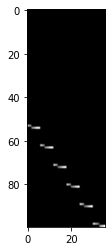

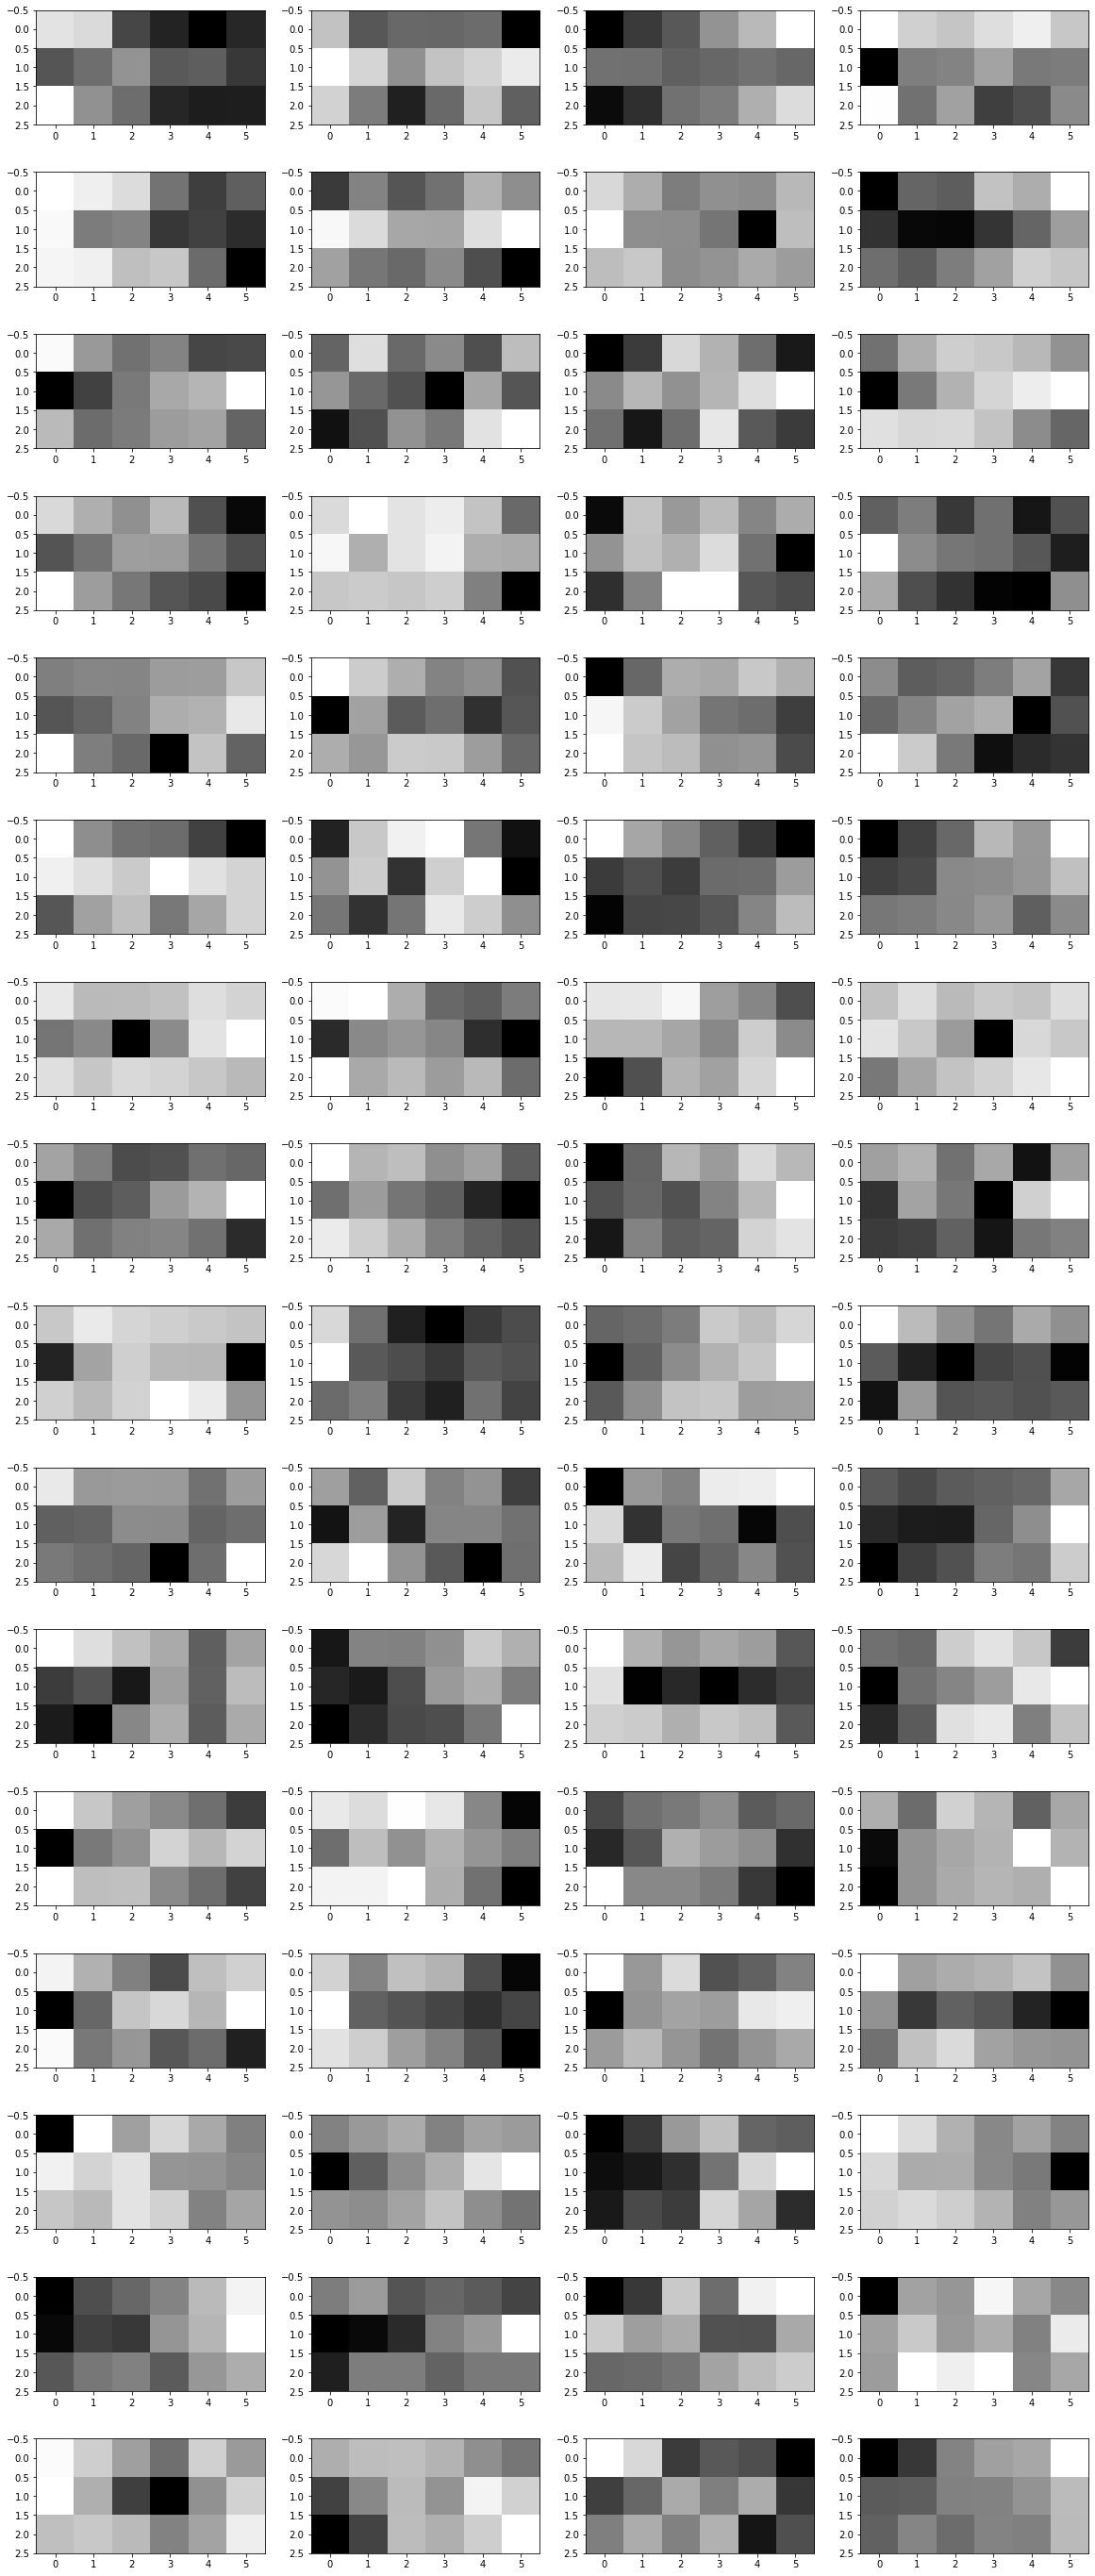

In [ ]:
convLayer = np.array(model.layers[1].get_weights()[0])[:,:,0,:]
print("convLayer Shape",convLayer.shape)
print("convLayer, first:\n",convLayer[:,:,0])


# modelCounter = 0

# def getLayer(model):
#   global modelCounter
#   print(modelCounter)
#   try:
#     val = np.array(model.layers[modelCounter].get_weights()[0])[:,:,0,:]
#     while not isinstance(val,keras.layers.Conv2D):
#       modelCounter+=1
#       print(modelCounter)
#       val = np.array(model.layers[modelCounter].get_weights()[0])[:,:,0,:]
#     return val
#   except IndexError:
#     print("out of bounds")
#     return

# print(isinstance(getLayer(model),keras.layers.Conv2D))

def drawConv2D(layer):
  print("\nCONV2D LAYER\n")
  x, _ = next(train_generator)
  x = x[0,:,:,0]
  print(x.shape)
  plt.imshow(x, cmap='gray')
  print("in function")
  val = np.size(layer,-1)
  print("val:",val)
  x_v = int(val/4)
  y_v = 4
  print("rows,cols: ",x_v,y_v)
  f, ax = plt.subplots(x_v,y_v,figsize=(20,50))
  for x in range(val):
    ax[int(x%(x_v)),int(x/(x_v))].imshow(convLayer[:,:,x],cmap='gray')
  print("\n\n")
    
drawConv2D(convLayer)



### Graphs

dict_keys(['loss', 'phi_output_loss', 'z_output_loss', 'phi_output_mae', 'z_output_mae', 'val_loss', 'val_phi_output_loss', 'val_z_output_loss', 'val_phi_output_mae', 'val_z_output_mae'])
generator created for: VALIDATION/images.raw.gz
100/100 [==============================] - 1s 5ms/step - loss: 0.0775 - phi_output_loss: 0.0213 - z_output_loss: 0.5664 - phi_output_mae: 0.1138 - z_output_mae: 0.4023


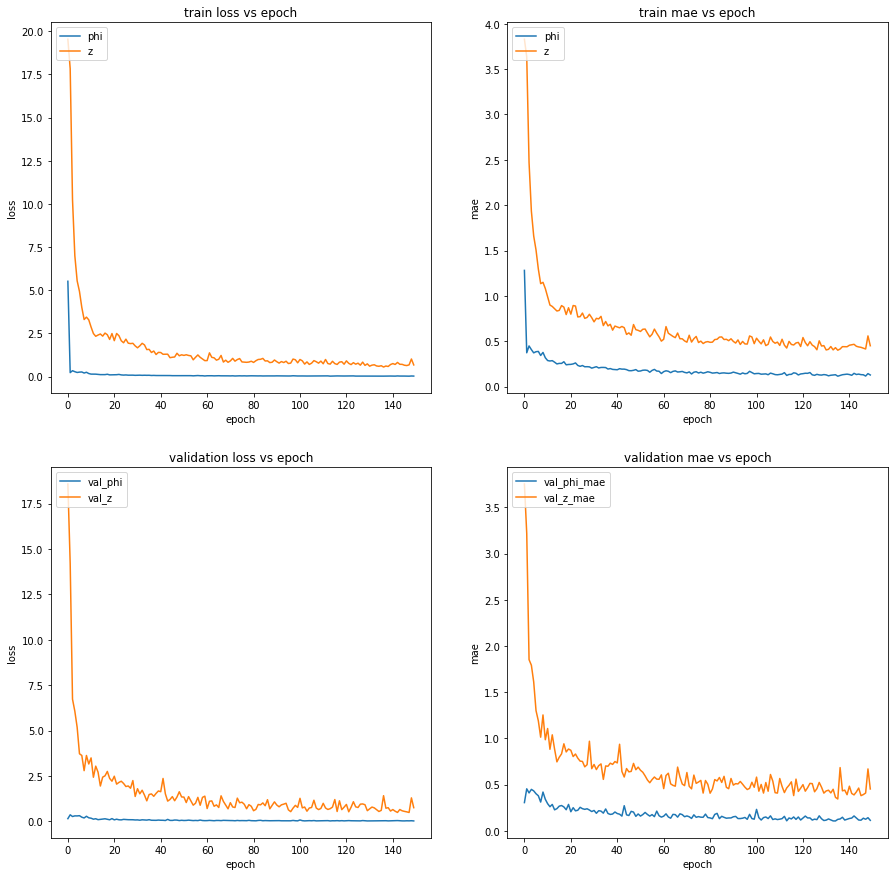

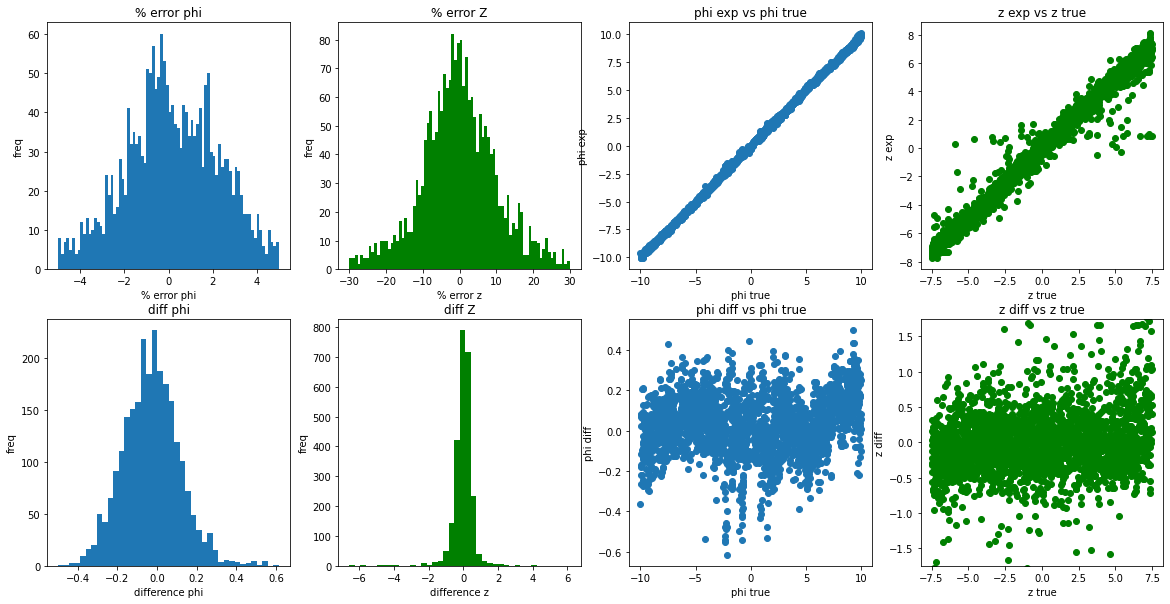

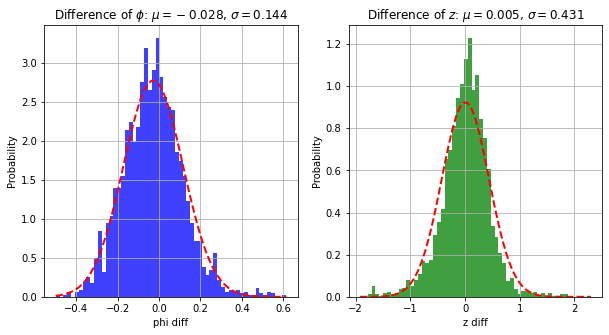

In [ ]:

doModelGraphs = True

if doModelGraphs:
  print(H.history.keys())
  try:
    fig, axs = plt.subplots(2,2,figsize=(15,15))


    axs[0,0].plot(H.history['phi_output_loss'])
    axs[0,0].plot(H.history['z_output_loss'])
    axs[0,0].set_title('train loss vs epoch')
    axs[0,0].set_ylabel('loss')
    axs[0,0].set_xlabel('epoch')
    axs[0,0].legend(['phi','z'],loc='upper left')

    axs[0,1].plot(H.history['phi_output_mae'])
    axs[0,1].plot(H.history['z_output_mae'])
    axs[0,1].set_title('train mae vs epoch')
    axs[0,1].set_ylabel('mae')
    axs[0,1].set_xlabel('epoch')
    axs[0,1].legend(['phi','z'],loc='upper left')

    axs[1,0].plot(H.history['val_phi_output_loss'])
    axs[1,0].plot(H.history['val_z_output_loss'])
    axs[1,0].set_title('validation loss vs epoch')
    axs[1,0].set_ylabel('loss')
    axs[1,0].set_xlabel('epoch')
    axs[1,0].legend(['val_phi','val_z'],loc='upper left')

    axs[1,1].plot(H.history['val_phi_output_mae'])
    axs[1,1].plot(H.history['val_z_output_mae'])
    axs[1,1].set_title('validation mae vs epoch')
    axs[1,1].set_ylabel('mae')
    axs[1,1].set_xlabel('epoch')
    axs[1,1].legend(['val_phi_mae','val_z_mae'],loc='upper left')

  except e:
    print("error:")
    print(e)


test_generator = generate_arrays_from_file(valdf,"VALIDATION/")
diff_phi = np.array([])
diff_phi_err = np.array([])
diff_z = np.array([])
diff_z_err = np.array([])
z_t = np.array([])
phi_t = np.array([])
z_e = np.array([])
phi_e = np.array([])

ev = model.evaluate(test_generator,steps=100,batch_size=32)

for i in range(100):
  test = next(test_generator)
  test = np.array(test)
  test_x = test[0]
  test_y = test[1]

  pred = model.predict(x=test_x,verbose=0)

  prt = False

  # diff_phi = []
  # diff_phi_err = []
  # diff_z = []
  # diff_z_err = []

  if prt: print("phi:::\n")
  for i in range(25):
    true = np.reshape(test_y["phi_output"],[32,1])[i]
    exp = pred["phi_output"][i]
    phi_t = np.append(phi_t,true)
    phi_e = np.append(phi_e,exp)

    diff_phi = np.append(diff_phi,exp-true)
    diff_phi_err = np.append(diff_phi_err,((abs(exp-true)/true)*100))

    if prt: print(exp," : ",true," : ",diff_phi[-1])

  if prt: print("\n\nz::::\n")
  for i in range(25):
    true = np.reshape(test_y["z_output"],[32,1])[i]
    exp = pred["z_output"][i]
    z_t = np.append(z_t,true)
    z_e = np.append(z_e,exp)

    diff_z = np.append(diff_z,exp-true)
    diff_z_err = np.append(diff_z_err,((abs(exp-true)/true)*100))

    if prt: print(exp," : ",true," : ",diff_z[-1])

  # plt.hist(diff_phi_err,20,[-100,100])
  # plt.title('% error phi')
  # plt.ylabel('freq')
  # plt.xlabel('% error phi')
  # plt.show()


val = np.array([diff_phi,diff_phi_err,diff_z,diff_z_err,z_t,phi_t,z_e,phi_e])


if False:
  with open("drive/My Drive/data.pkl","wb") as output:
    pickle.dump(val, output, pickle.HIGHEST_PROTOCOL)

doGraphs = True


if doGraphs:
  fig, axs = plt.subplots(2,4,figsize=(20,10))

  # axs[0,0].hist(diff_phi_err,80,[-100,100])
  axs[0,0].hist(diff_phi_err,80,[-5,5])
  axs[0,0].set_title('% error phi')
  axs[0,0].set_ylabel('freq')
  axs[0,0].set_xlabel('% error phi')

  # axs[0,1].hist(diff_z_err,80,[-100,100],color='g')
  axs[0,1].hist(diff_z_err,80,[-30,30],color='g')
  axs[0,1].set_title('% error Z')
  axs[0,1].set_ylabel('freq')
  axs[0,1].set_xlabel('% error z')

  axs[1,0].hist(diff_phi,40)
  axs[1,0].set_title('diff phi')
  axs[1,0].set_ylabel('freq')
  axs[1,0].set_xlabel('difference phi')

  axs[1,1].hist(diff_z,40,color='g')
  axs[1,1].set_title('diff Z')
  axs[1,1].set_ylabel('freq')
  axs[1,1].set_xlabel('difference z')


  axs[0,2].scatter(phi_t,phi_e)
  axs[0,2].set_title('phi exp vs phi true')
  axs[0,2].set_ylabel('phi exp')
  axs[0,2].set_xlabel('phi true')

  axs[0,3].scatter(z_t,z_e,color='g')
  axs[0,3].set_title('z exp vs z true')
  axs[0,3].set_ylabel('z exp')
  axs[0,3].set_xlabel('z true')

  axs[1,2].scatter(phi_t, phi_t-phi_e)
  axs[1,2].set_title('phi diff vs phi true')
  axs[1,2].set_ylabel('phi diff')
  axs[1,2].set_xlabel('phi true')

  axs[1,3].scatter(z_t, z_t-z_e,color='g')
  axs[1,3].set_title('z diff vs z true')
  axs[1,3].set_ylabel('z diff')
  axs[1,3].set_xlabel('z true')
  axs[1,3].set_ylim([-1.75,1.75])

from scipy.stats import norm

f, ax = plt.subplots(1,2,figsize=(10,5))

(mu, sigma) = norm.fit(diff_phi)
_, bins, _ = ax[0].hist(diff_phi, 60, facecolor="blue", alpha=0.75, density=True)
y = norm.pdf(bins, mu, sigma)
l = ax[0].plot(bins, y, 'r--', linewidth=2)

ax[0].set_xlabel('phi diff')
ax[0].set_ylabel('Probability')
ax[0].set_title("Difference of $\phi$: $\mu={mu:.3f}$, $\sigma={sigma:.3f}$".format(mu=mu, sigma=sigma))
ax[0].grid(True)


for index in range(len(diff_z)):
  if index >= len(diff_z):
    break
  if abs(diff_z[index]) > 2:
    # print("cutting : ", index)
    diff_z = np.append(diff_z[0:index],diff_z[index+1:])
    index-=1


(mu, sigma) = norm.fit(diff_z)
_, bins, _ = ax[1].hist(diff_z, 60, facecolor="green", alpha=0.75, density=True)
y = norm.pdf(bins, mu, sigma)
l = ax[1].plot(bins, y, 'r--', linewidth=2)

ax[1].set_xlabel('z diff')
ax[1].set_ylabel('Probability')
ax[1].set_title("Difference of $z$: $\mu={mu:.3f}$, $\sigma={sigma:.3f}$".format(mu=mu, sigma=sigma))
ax[1].grid(True)

### Graphs and info

In [ ]:
from scipy.stats import norm
f, ax = plt.subplots(1,2,figsize=(10,5))

(mu, sigma) = norm.fit(diff_phi)
_, bins, _ = ax[0].hist(diff_phi, 60, facecolor="blue", alpha=0.75, density=True)
y = norm.pdf(bins, mu, sigma)
l = ax[0].plot(bins, y, 'r--', linewidth=2)

ax[0].set_xlabel('phi diff')
ax[0].set_ylabel('Probability')
ax[0].set_title("Difference of $\phi$: $\mu={mu:.3f}$, $\sigma={sigma:.3f}$".format(mu=mu, sigma=sigma))
ax[0].grid(True)


# Cut large and small data, limit data to middle

for index in range(len(diff_z)):
  if index >= len(diff_z):
    break
  if abs(diff_z[index]) > 2:
    # print("cutting : ", index)
    diff_z = np.append(diff_z[0:index],diff_z[index+1:])
    index-=1

(mu, sigma) = norm.fit(diff_z)
_, bins, _ = ax[1].hist(diff_z, 60, facecolor="green", alpha=0.75, density=True)
y = norm.pdf(bins, mu, sigma)
l = ax[1].plot(bins, y, 'r--', linewidth=2)

ax[1].set_xlabel('z diff')
ax[1].set_ylabel('Probability')
ax[1].set_title("Difference of $z$: $\mu={mu:.3f}$, $\sigma={sigma:.3f}$".format(mu=mu, sigma=sigma))
ax[1].grid(True)

for index in range(len(diff_z)):
  if abs(diff_z[index]) > 2:
    print("found one at",index)


# model.save("model.keras",save_format="h5")

### Testing

In [ ]:
from scipy.stats import norm

f, ax = plt.subplots(1,2,figsize=(10,5))

(mu, sigma) = norm.fit(diff_phi)
_, bins, _ = ax[0].hist(diff_phi, 60, facecolor="blue", alpha=0.75, density=True)
y = norm.pdf(bins, mu, sigma)
l = ax[0].plot(bins, y, 'r--', linewidth=2)

ax[0].set_xlabel('phi diff')
ax[0].set_ylabel('Probability')
ax[0].set_title("Difference of $\phi$: $\mu={mu:.2f}$, $\sigma={sigma:.2f}$".format(mu=mu, sigma=sigma))
ax[0].grid(True)


(mu, sigma) = norm.fit(diff_z)
_, bins, _ = ax[1].hist(diff_z, 60, facecolor="green", alpha=0.75, density=True)
y = norm.pdf(bins, mu, sigma)
l = ax[1].plot(bins, y, 'r--', linewidth=2)

ax[1].set_xlabel('z diff')
ax[1].set_ylabel('Probability')
ax[1].set_title("Difference of $z$: $\mu={mu:.2f}$, $\sigma={sigma:.2f}$".format(mu=mu, sigma=sigma))
ax[1].grid(True)


# (mu, sigma) = norm.fit(diff_z_err)
# _, bins, _ = ax[1,0].hist(diff_z_err, 60, facecolor="blue", alpha=0.75, density=True)
# y = norm.pdf(bins, mu, sigma)
# l = ax[1,0].plot(bins, y, 'r--', linewidth=2)

# ax[1,0].set_xlim([-100,100])
# ax[1,0].set_xlabel('z % err')
# ax[1,0].set_ylabel('Probability')
# ax[1,0].set_title("% Error of $z$: $\mu={mu:.2f}$, $\sigma={sigma:.2f}$".format(mu=mu, sigma=sigma))
# ax[1,0].grid(True)

# (mu, sigma) = norm.fit(diff_phi_err)
# _, bins, _ = ax[1,1].hist(diff_phi_err, 60, facecolor="green", alpha=0.75, density=True)
# y = norm.pdf(bins, mu, sigma)
# l = ax[1,1].plot(bins, y, 'r--', linewidth=2)

# ax[1,1].set_xlim([-100,100])
# ax[1,1].set_xlabel('phi % err')
# ax[1,1].set_ylabel('Probability')
# ax[1,1].set_title("% Error of $\phi$: $\mu={mu:.2f}$, $\sigma={sigma:.2f}$".format(mu=mu, sigma=sigma))
# ax[1,1].grid(True)

